In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn import preprocessing

# Arguments

In [60]:
args = {'noise':0.01,
        'percent training data':0.7,
        'spec scale':10**12,

        'forward learning rate':0.01,
        'tandem learning rate':0.01,

        'forward training epochs':1000,
        'tandem training epochs':5000,

        'forward training criterion':nn.L1Loss(),
        'tandem training criterion':nn.L1Loss(),
        'testing criterion':nn.L1Loss(),
        
        'optimizer':torch.optim.Rprop,

        'percent inverse':0.5
        }

now = datetime.now()

# Data Prep

In [61]:
# fn to convert dataframes to tensors
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

In [62]:
# load and sepearate data
df = pd.read_excel('data_3nm.xlsx')

spec = df.iloc[:,11:] 
temp = df.iloc[:,:11]

In [63]:
# function to add noise as a percentage 
def add_noise(data, percentage):
    std_dev = percentage * data.std().sum()/len(data)
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [64]:
# add noise
spec_noisy = add_noise(spec, args['noise'])

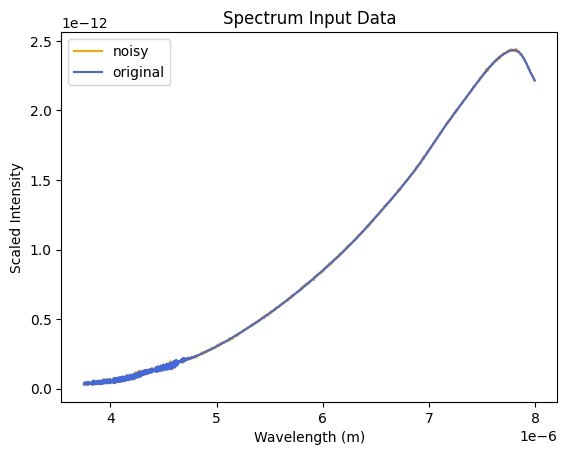

In [65]:
# plot specturm data with added noise

plt.title('Spectrum Input Data')
plt.plot(spec_noisy.iloc[0], label='noisy', color='orange')
plt.plot(spec.iloc[0], label='original', color='royalblue')
plt.xlabel("Wavelength (m)")
plt.ylabel("Scaled Intensity")
plt.legend()
plt.show()

In [66]:
# Standardize both the temperature and spectrum data (as both will be passed as inputs in separte parts of the network)

# Standardize clean and noisy spectrum data
spec_scaler = preprocessing.StandardScaler()
spec_scaler.fit(spec)
spec_scaled = spec_scaler.transform(spec)

spec_scaler.fit(spec_noisy)
spec_noisy_scaled = spec_scaler.transform(spec_noisy)

spec_unscaled_df = pd.DataFrame(spec, columns=spec.columns)
spec_scaled_df = pd.DataFrame(spec_scaled, columns=spec.columns)
spec_noisy_scaled_df = pd.DataFrame(spec_noisy_scaled, columns = spec.columns)



# Standardize temperature data
temp_scaler = preprocessing.StandardScaler()
temp_scaler.fit(temp)
temp_scaled = temp_scaler.transform(temp)

temp_unscaled_df = pd.DataFrame(temp, columns=temp.columns)
temp_scaled_df = pd.DataFrame(temp_scaled, columns=temp.columns)


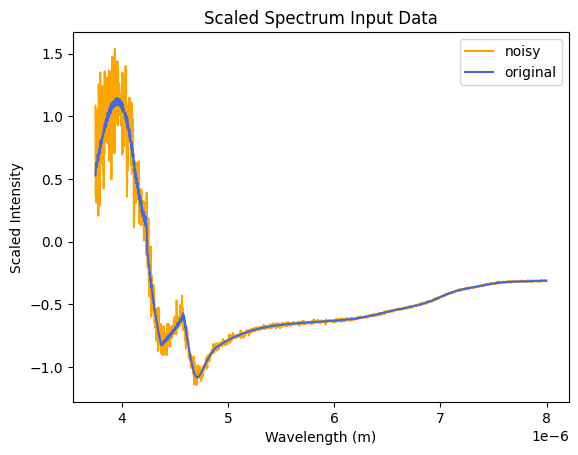

In [67]:
# plot scaled spectrum data

plt.title('Scaled Spectrum Input Data')
plt.plot(spec_noisy_scaled_df.iloc[0], label='noisy', color='orange')
plt.plot(spec_scaled_df.iloc[0], label='original', color='royalblue')
plt.xlabel("Wavelength (m)")
plt.ylabel("Scaled Intensity")
plt.legend()
plt.show()

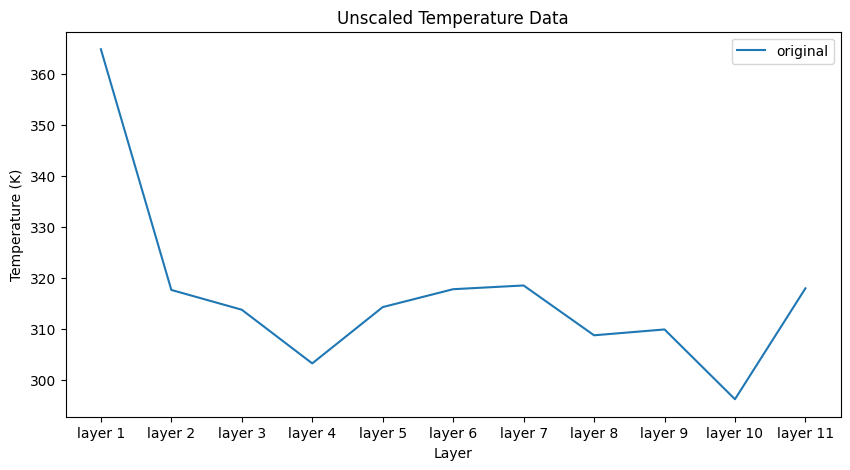

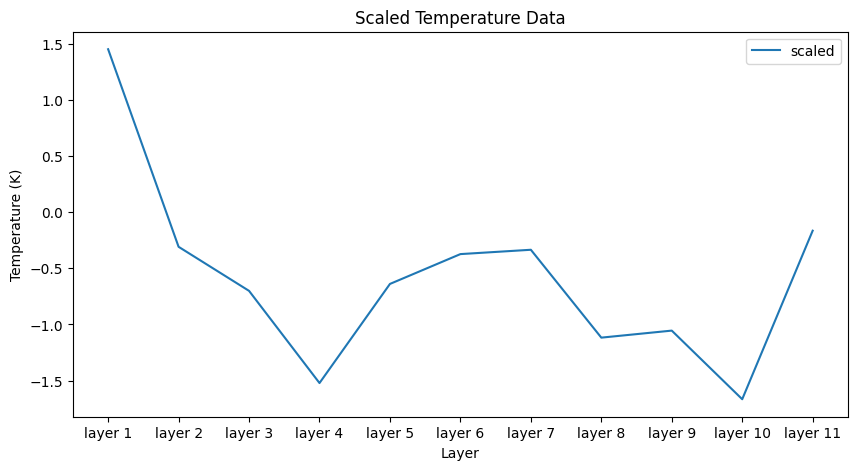

In [68]:
# plot scaled and unscaled temperature data

plt.figure(figsize=(10, 5))
plt.title('Unscaled Temperature Data')
plt.plot(temp_unscaled_df.iloc[0], label='original')
plt.xlabel("Layer")
plt.ylabel("Temperature (K)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title('Scaled Temperature Data')
plt.plot(temp_scaled_df.iloc[0], label='scaled')
plt.xlabel("Layer")
plt.ylabel("Temperature (K)")
plt.legend()
plt.show()


In [69]:
# do train-test split on the data and convert to tensors
spec_train_df, spec_test_df, temp_train_df, temp_test_df = train_test_split(spec_noisy_scaled_df, temp_scaled_df, train_size=args['percent training data'], random_state=101)

spec_train = df_to_tensor(spec_train_df)
spec_test = df_to_tensor(spec_test_df)
temp_train = df_to_tensor(temp_train_df)
temp_test = df_to_tensor(temp_test_df)

In [70]:
spec_train

tensor([[-1.2982, -1.3602, -1.6533,  ..., -1.1238, -1.1255, -1.1263],
        [ 0.1059, -1.3902, -0.2111,  ...,  1.6778,  1.6742,  1.6804],
        [-1.3357, -0.6667, -0.6483,  ..., -0.6894, -0.6898, -0.6967],
        ...,
        [-1.3510, -1.3984, -1.7351,  ..., -0.9918, -0.9939, -0.9975],
        [ 0.4212,  1.1938,  0.9630,  ...,  0.2044,  0.2150,  0.2050],
        [-0.3876, -0.0138, -0.6919,  ...,  1.4707,  1.4668,  1.4663]])

In [71]:
temp_train

tensor([[-1.5220, -1.9154, -1.4147,  ..., -1.1235, -0.9571, -1.2245],
        [-1.3278, -0.8065,  0.8848,  ..., -1.5479, -0.7532,  1.5013],
        [-0.6747, -1.6201, -0.2056,  ..., -1.7734, -2.0478, -0.6061],
        ...,
        [-1.0219, -1.3482, -0.7763,  ..., -1.2900, -1.8831, -1.0255],
        [ 0.5026,  1.3870,  1.6597,  ...,  0.1302,  0.0124,  0.3558],
        [-1.0255, -2.1969, -1.4952,  ...,  1.7538,  1.0773,  1.3544]])

# Model Design

In [72]:
# design forward network (spec -> temp)
class ForwardNet(nn.Module):
    def __init__(self, middle_size, io_size):
        super(ForwardNet, self).__init__()
        self.lin1 = nn.Linear(middle_size, 60)
        self.lin2 = nn.Linear(60, 45)
        self.lin3 = nn.Linear(45, 30)
        self.lin4 = nn.Linear(30, 30)
        self.lin5 = nn.Linear(30, 30)
        self.lin_fin = nn.Linear(30, io_size)


    def forward(self, temp):
        x = F.leaky_relu(self.lin1(temp))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = F.leaky_relu(self.lin5(x))
        pred_spec = self.lin_fin(x)
        return pred_spec

In [73]:
# design inverse network (temp -> spec)
class InverseNet(nn.Module):
    def __init__(self, io_size, middle_size):
        super(InverseNet, self).__init__()
        self.lin1 = nn.Linear(io_size, 30)
        self.lin2 = nn.Linear(30, 45)
        self.lin3 = nn.Linear(45, 60)
        self.lin4 = nn.Linear(60, 60)
        self.lin5 = nn.Linear(60, 60)
        self.lin_fin = nn.Linear(60, middle_size)

    def forward(self, spec):
        x = F.leaky_relu(self.lin1(spec))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = F.leaky_relu(self.lin5(x))
        pred_temp = self.lin_fin(x)
        return pred_temp

In [74]:
# design tandem network (spec -> temp -> spec), relevant output being predicted temp
class TandemNet(nn.Module):
    def __init__(self, forward_model, inverse_model):
        super(TandemNet, self).__init__()
        self.forward_model = forward_model
        self.inverse_model = inverse_model

    def forward(self, spec_train):
        pred_temp = self.inverse_model(spec_train)
        pred_spec = self.forward_model(pred_temp)
        return pred_temp, pred_spec

In [75]:
# define size of layers based on shape of the data
_, middle_size = temp.shape
_, io_size = spec_noisy_scaled_df.shape

# define variables for each model
forward_model = ForwardNet(middle_size, io_size)
inverse_model = InverseNet(io_size, middle_size)
tandem_net = TandemNet(forward_model, inverse_model)

# Training Loop

In [76]:
# define training function for the forward model (spec -> temp)
def train_forward_model(forward_model, temp_train):
    print('FORWARD MODEL TRAINING')

    forward_loss_list = []
    forward_loss_sum = 0

    num_forward_epochs = args['forward training epochs']
    criterion = args['forward training criterion']
    optimizer = args['optimizer'](forward_model.parameters(), lr=args['forward learning rate'])

    for epoch in range(num_forward_epochs):
        # forward pass and loss
        pred_spec = forward_model(temp_train)
        loss = criterion(spec_train, pred_spec)

        # empty gradients
        optimizer.zero_grad()

        # backward pass
        loss.backward()

        # update
        optimizer.step()

        # find average loss after first 100 epochs
        if epoch > 100:
            forward_loss_sum += loss.item()

        forward_loss_list.append(loss.item())

        # print loss every 10% of epochs
        if (epoch + 1) % (num_forward_epochs / 10) == 0:
            print(f'forward epoch: {epoch + 1}, forward loss = {loss}')

    avg_forward_loss = forward_loss_sum / (num_forward_epochs - 100)
    print(f'\nAVERAGE FORWARD LOSS: {avg_forward_loss}\n')

    return forward_loss_list
        

In [77]:
# define training function for the tandem model (utilizing the pre-trained forward model)
def train_tandem_model(tandem_net, spec_train):
    print('\nINVERSE MODEL TRAINING')

    # Fix the parameters of the forward model
    for param in forward_model.parameters():
        param.requires_grad = False

    tandem_loss_list = []
    inverse_loss_list = []
    
    inverse_loss_sum = 0

    num_inverse_epochs = args['tandem training epochs']
    criterion = args['tandem training criterion']
    optimizer = args['optimizer'](tandem_net.parameters(), lr=args['tandem learning rate'])
    percent_inverse = args['percent inverse']

    for epoch in range(num_inverse_epochs):
        # pass through tandem model and calculate both inverse (temp) and tandem (spec) losses
        pred_temp, pred_spec = tandem_net(spec_train)
        inverse_loss = criterion(temp_train, pred_temp)
        tandem_loss = criterion(spec_train, pred_spec)

        # empty gradients
        optimizer.zero_grad()

        # for first chunk of epochs, train tandem network
        if epoch < (num_inverse_epochs * (1 - percent_inverse)):
            tandem_loss.backward()

        # for second chunk of epochs, train inverse network (refine predictions, optimizing for pred_temp)
        else:
            inverse_loss.backward()
            # find average loss after first 100 epochs
            if epoch > 100:
                inverse_loss_sum += inverse_loss.item()

        # update
        optimizer.step()

        tandem_loss_list.append(tandem_loss.item())
        inverse_loss_list.append(inverse_loss.item())

        # print losses every 10% of epochs
        if (epoch + 1) % (num_inverse_epochs / 10) == 0:
            print(f'forward epoch: {epoch + 1}, tandem loss = {tandem_loss}, *inverse loss* = {inverse_loss}')

    avg_inverse_loss = inverse_loss_sum / ((num_inverse_epochs * percent_inverse) - 100)
    print(f'\nAVERAGE INVERSE LOSS: {avg_inverse_loss}')
    
    return tandem_loss_list, inverse_loss_list

In [78]:
# train models
forward_loss_list = train_forward_model(forward_model, temp_train)
tandem_loss_list, inverse_loss_list = train_tandem_model(tandem_net, spec_train)

FORWARD MODEL TRAINING


forward epoch: 100, forward loss = 0.06577873229980469
forward epoch: 200, forward loss = 0.04890509322285652
forward epoch: 300, forward loss = 0.0450165793299675
forward epoch: 400, forward loss = 0.04335350543260574
forward epoch: 500, forward loss = 0.042418330907821655
forward epoch: 600, forward loss = 0.04182922840118408
forward epoch: 700, forward loss = 0.041447222232818604
forward epoch: 800, forward loss = 0.04116888344287872
forward epoch: 900, forward loss = 0.04093775525689125
forward epoch: 1000, forward loss = 0.04075302928686142

AVERAGE FORWARD LOSS: 0.043820203977326555


INVERSE MODEL TRAINING
forward epoch: 500, tandem loss = 0.044076528400182724, *inverse loss* = 0.6540446281433105
forward epoch: 1000, tandem loss = 0.0426449328660965, *inverse loss* = 0.6417168378829956
forward epoch: 1500, tandem loss = 0.04226088523864746, *inverse loss* = 0.6377136707305908
forward epoch: 2000, tandem loss = 0.042104315012693405, *inverse loss* = 0.6354503035545349
forward epo

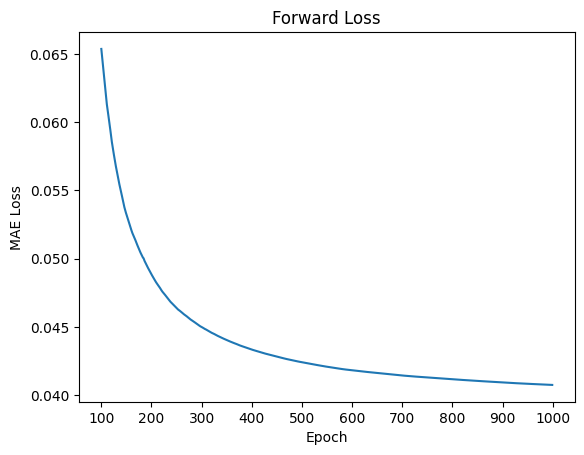

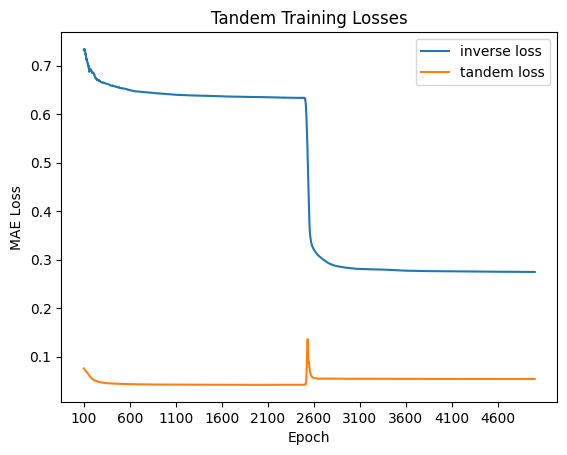

In [79]:
# plot losses after first 100 epochs

# add 100 to x-axis values
x_values = range(100, args['forward training epochs'])
plt.plot(x_values, forward_loss_list[100:])
plt.xticks(range(100, args['forward training epochs'] + 100, args['forward training epochs'] // 10))

plt.title("Forward Loss")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss")
plt.show()


# plot tandem and inverse losses after first 100 epochs
x_values = range(100, args['tandem training epochs'])
plt.plot(x_values, inverse_loss_list[100:], label='inverse loss')
plt.plot(x_values, tandem_loss_list[100:], label='tandem loss')
plt.xticks(range(100, args['tandem training epochs'] + 100, args['tandem training epochs'] // 10))

plt.title("Tandem Training Losses")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss")
plt.legend()
plt.show()

# Testing

In [80]:
# run tandem model with testing data
pred_temp, pred_spec = tandem_net(spec_test)

In [81]:
# unscale data appropriately
pred_temp = temp_scaler.inverse_transform(pred_temp.detach().numpy())
pred_spec = spec_scaler.inverse_transform(pred_spec.detach().numpy())
temp_test = temp_scaler.inverse_transform(temp_test.detach().numpy())
spec_test = spec_scaler.inverse_transform(spec_test.detach().numpy())

In [82]:
# plot predicted vs actual temperature for random set of samples
def plot_test_results(pred, actual, index):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {index}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')

    for i in range(len(pred)):
        diff = abs(pred[i] - actual[i])
        plt.text(i, pred[i] + 2, f"{diff:.2f}", fontsize=8, horizontalalignment='center', verticalalignment='center')

    plt.legend()
    plt.show()

test_losses: [3.4008502382220644, 9.851539796771425, 5.962980559377959, 4.91879277084813, 4.9806815869880445, 6.255152014530066, 6.415113506895123, 4.480319814970999, 3.9498849117394648, 4.189843565044981, 0.8620807069720644]


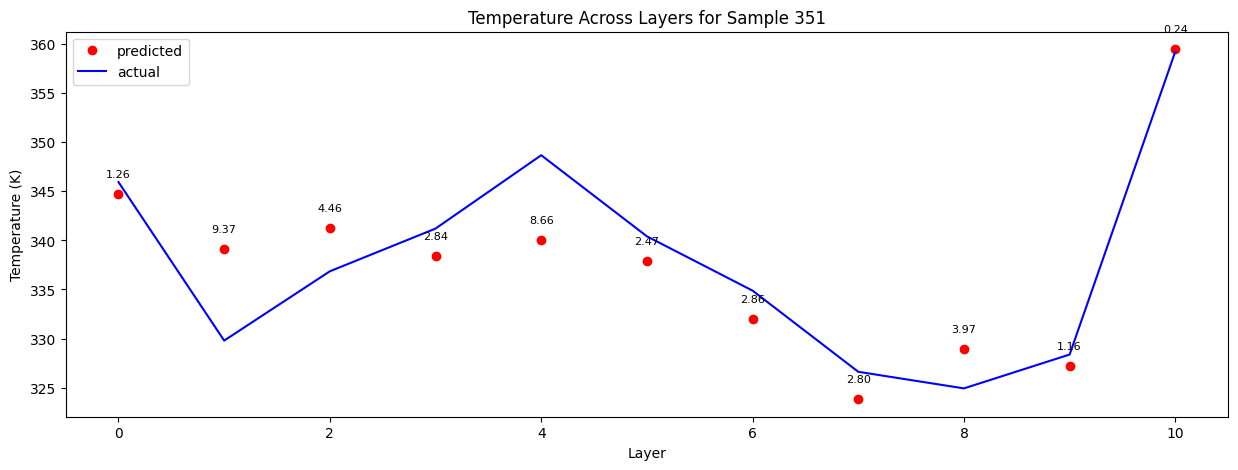

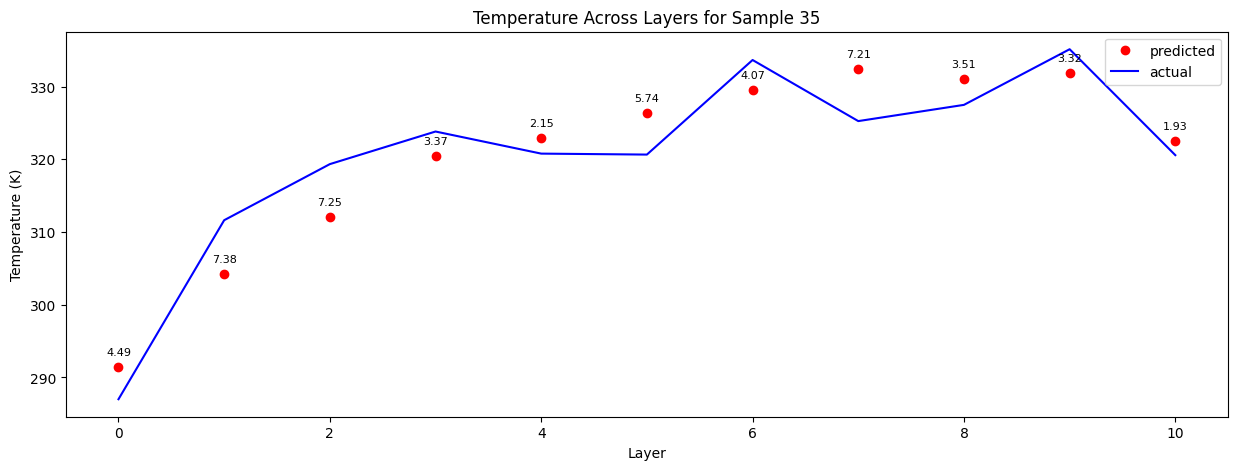

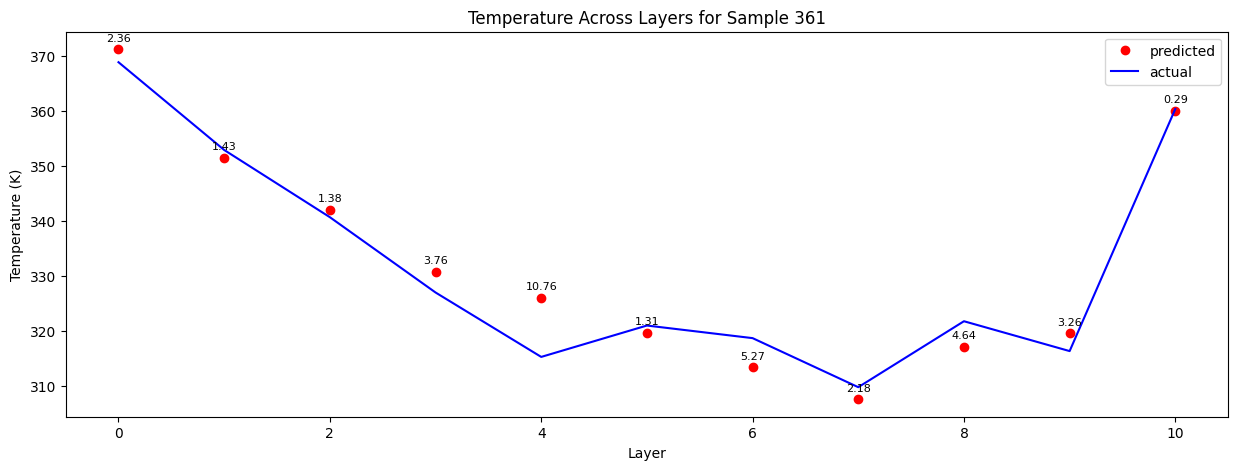

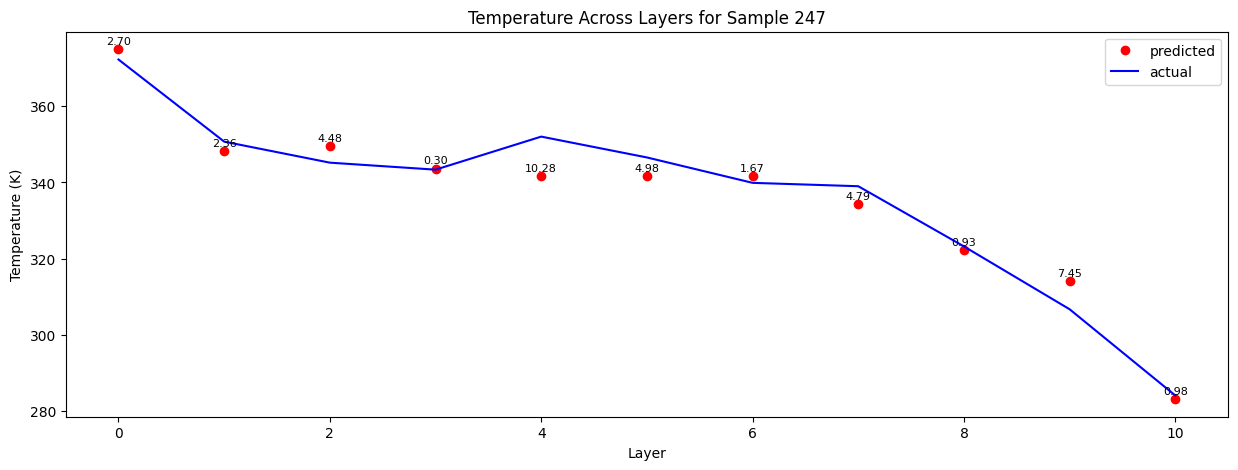

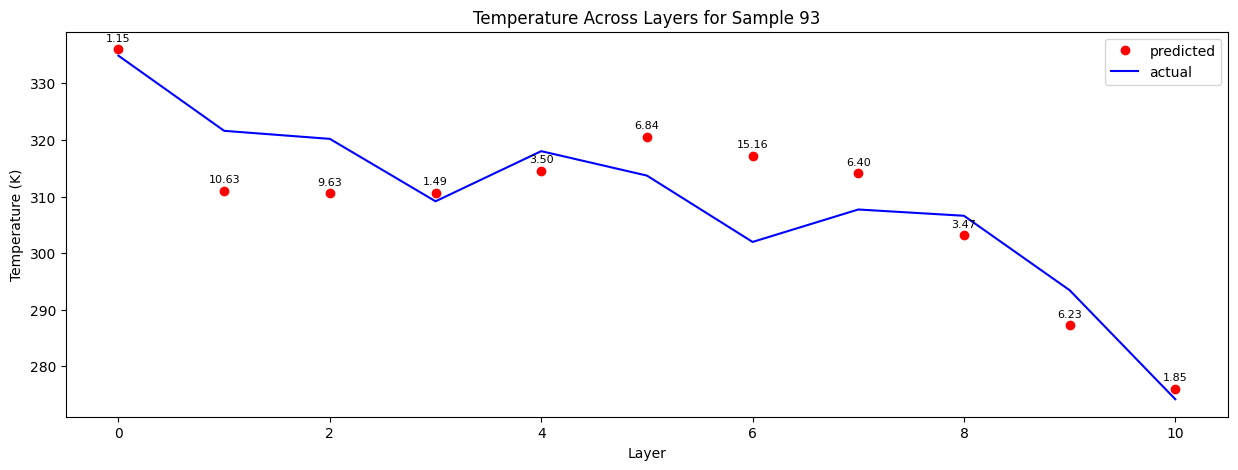

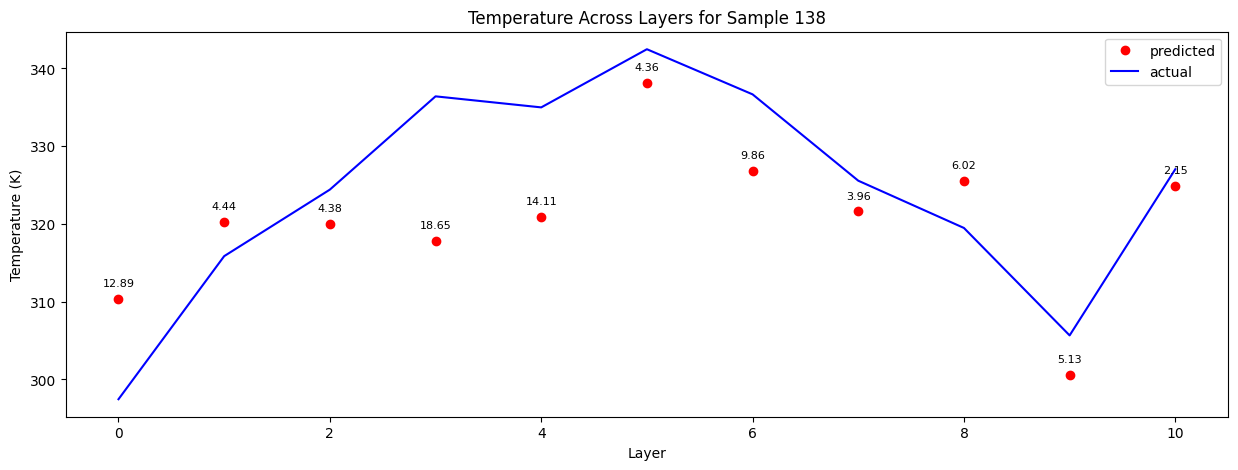

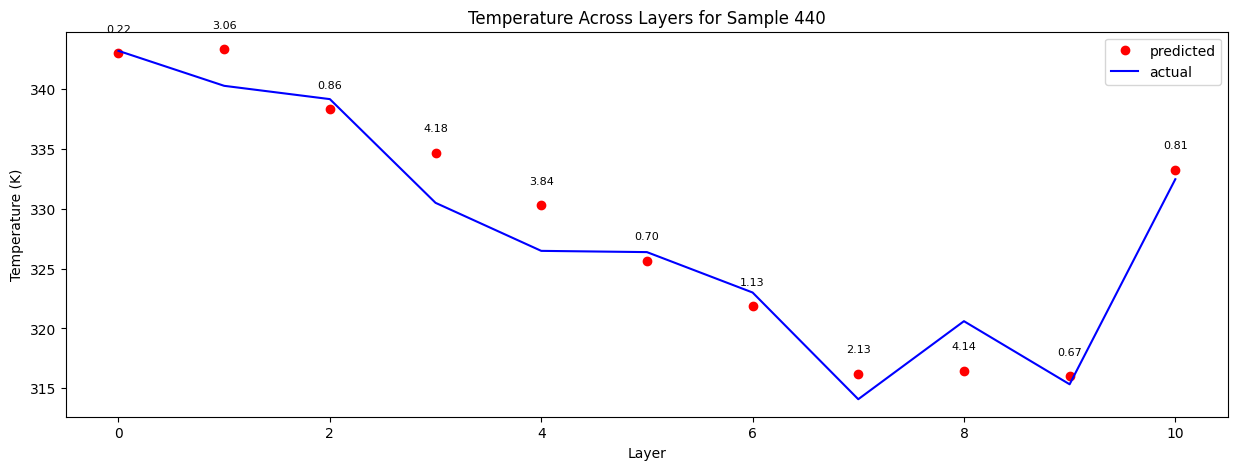

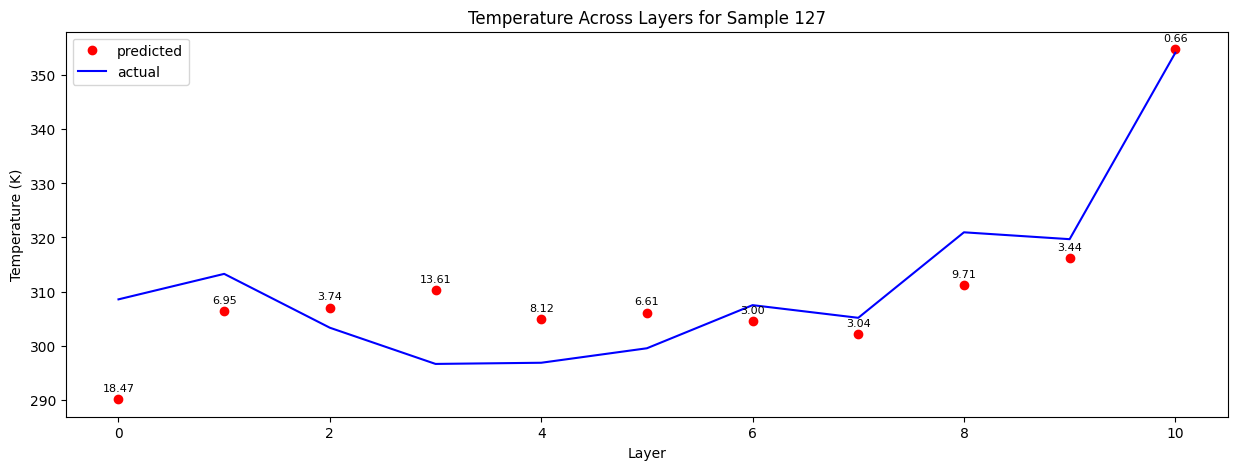

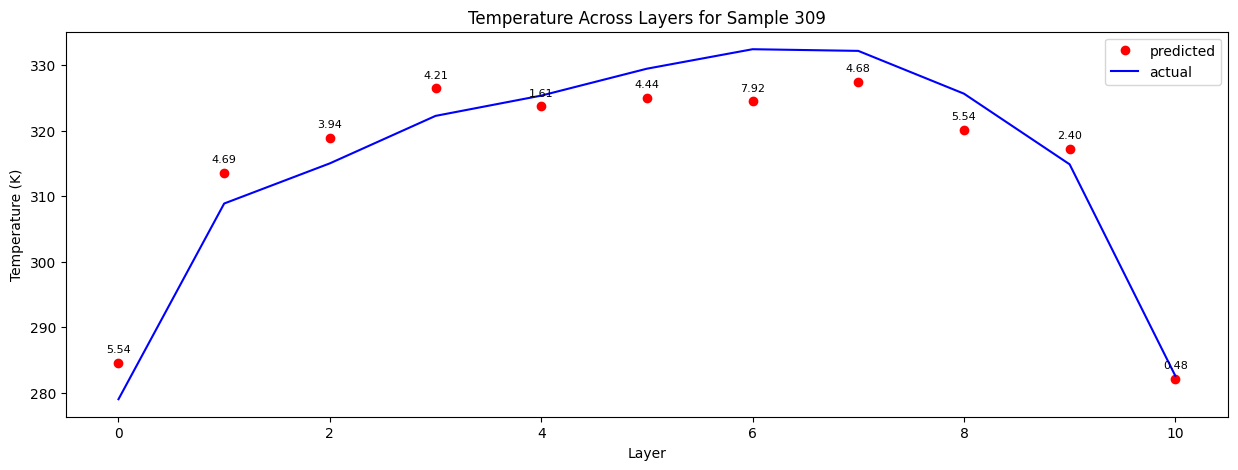

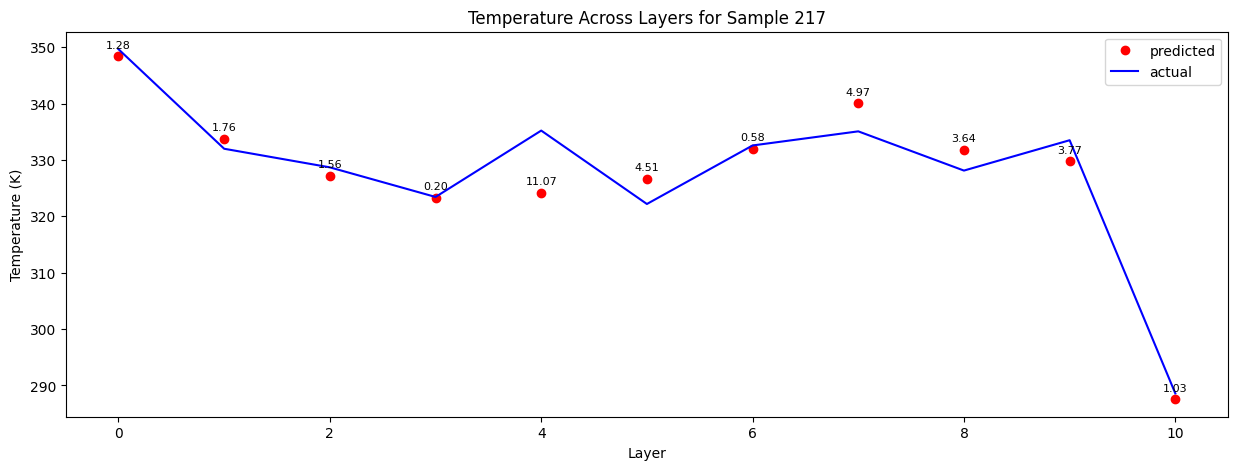

In [83]:
# plot spectrum --> temperature error
import random
num_graphs = 10
indices = []

test_losses = [0] * 11

with torch.no_grad():
    for i in range(len(pred_temp)):
    # sum loss for each entry
        for layer in range(len(pred_temp[0])):
            l1_loss = abs(pred_temp[i][layer] - temp_test[i][layer]).item()
            test_losses[layer] += l1_loss

    # divide by total number of entries to determine the average loss per layer
    for i in range(len(test_losses)):
        test_losses[i] = test_losses[i] / len(pred_temp)

    print(f'test_losses: {test_losses}')

    # select random samples to plot
    for i in range(0, num_graphs):
        n = random.randint(0, len(pred_temp))
        indices.append(n)

    # call plotting function
    for index in indices:
        plot_test_results(pred_temp[index], temp_test[index], index)


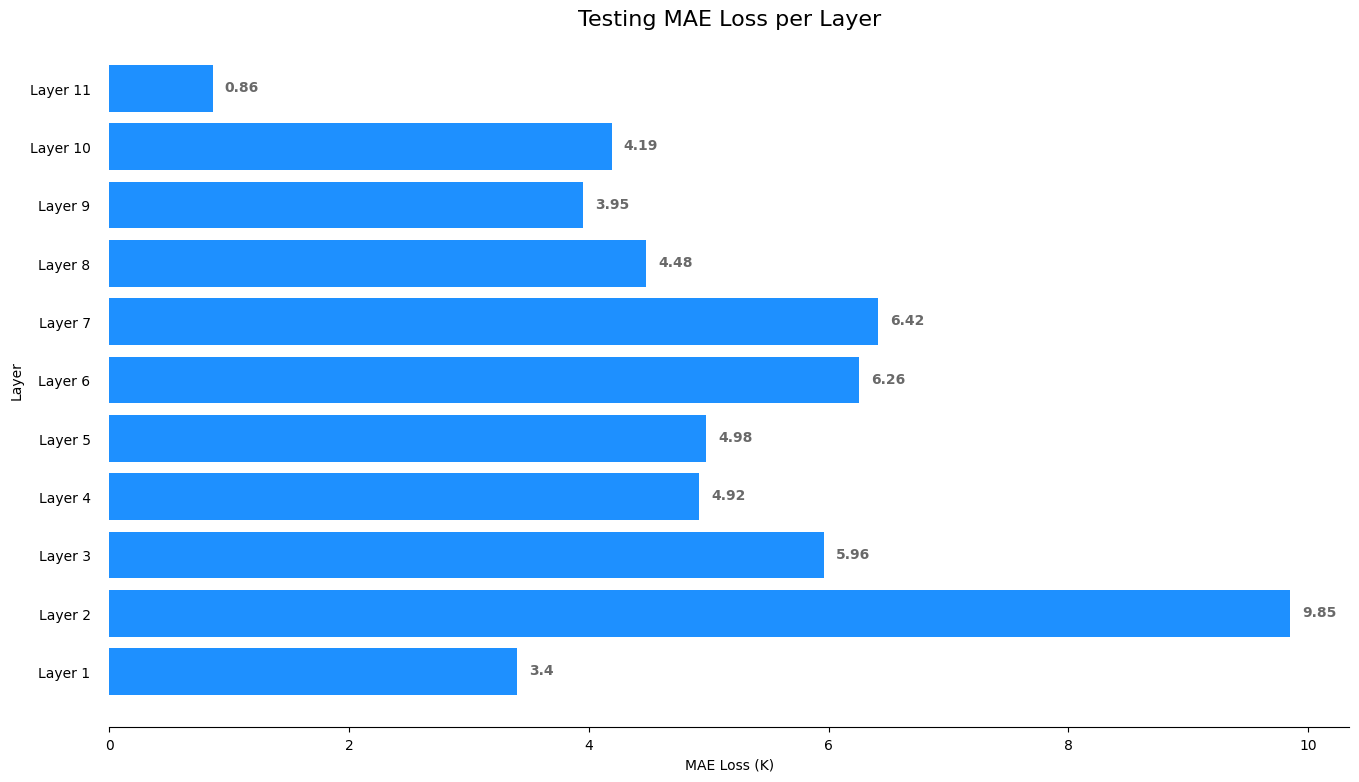

In [84]:
# Graph test losses per layer

# create list of layer names
layer_names = []
for i in range(1, 12):
    layer_names.append(f'Layer {i}')

# plot layer lossess
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(layer_names, test_losses, color ='dodgerblue')
 
# Remove axes splines and y-ticks
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.1, i.get_y()+0.35,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='dimgrey')

plt.title("Testing MAE Loss per Layer", color='black', fontsize=16)
plt.xlabel("MAE Loss (K)")
plt.ylabel("Layer")

plt.show()

In [85]:
with open('tandem_final_params.txt', "a") as f:
    f.write('===================================\n' +'|'.ljust(5) + f'{now.strftime("%m/%d/%Y, %H:%M:%S")}\n|\n')
    
    loss_str = ''
    for i in range(1, 12):
        loss_str += f'| layer {i} loss: '.ljust(20) + f'{test_losses[i-1]:.3f}\n'

    
    arg_str = ''
    for key in args:
        arg_str += f'| {key}:'.ljust(20) + f'{args[key]}\n'

    f.write('|'.ljust(10) + 'Losses\n' + f'|----------------------------------\n{loss_str}|\n'+ '|'.ljust(10) + 'Args' 
            + f'\n|----------------------------------\n{arg_str}====================================\n\n')

In [86]:
with open('tandem_results.txt', 'a') as file:
    file.write(f'{sum(test_losses)/len(test_losses)}\n')